In [1]:
!date

Tue May 16 08:59:55 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-ADHD'

In [107]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pickle
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

In [82]:
def fit_rsa(rdm_data,rdm_model):
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    vec = inVec
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())

    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):

    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]
    
    return triu_vec

In [83]:
df = pd.read_csv('./df_rsa.csv')
df

,Unnamed: 0,subjectkey,eventname,interview_age,sex,sexID,mri_info_deviceserialnumber,scannerID,IQ,sumSympt
0,0,NDAR_INV0VXEC29A,baseline_year_1_arm_1,125,F,1,HASH5ac2b20b,1,19.0,17
1,1,NDAR_INVXWXUUU18,baseline_year_1_arm_1,109,M,2,HASH69f406fa,2,20.0,9
2,2,NDAR_INVZ4NNCTMH,baseline_year_1_arm_1,125,F,1,HASH1314a204,3,18.0,10
3,3,NDAR_INVKT7E0NA1,baseline_year_1_arm_1,131,M,2,HASH4b0b8b05,4,17.0,18
4,4,NDAR_INV20CZ5PTX,baseline_year_1_arm_1,130,M,2,HASHdb2589d4,5,13.0,11
...,...,...,...,...,...,...,...,...,...,...
5007,5007,NDAR_INV1EGW0J5N,baseline_year_1_arm_1,109,M,2,HASHb640a1b8,7,20.0,0
5008,5008,NDAR_INV2F729N9A,baseline_year_1_arm_1,117,F,1,HASHc3bf3d9c,16,20.0,0
5009,5009,NDAR_INVMAW066K7,baseline_year_1_arm_1,120,F,1,HASH96a0c182,10,21.0,0
5010,5010,NDAR_INV5DJB8FFX,baseline_year_1_arm_1,114,F,1,HASH5ac2b20b,1,19.0,0


In [84]:
# ## Load data
# arr_adhd = np.load('./Data/brain_arr_64_ADHD_959.npz')
# arr_td = np.load('./Data/brain_arr_64_TD_3874.npz')
# print(list(arr_adhd.keys()))

# arr = np.concatenate((arr_adhd['arr'],arr_td['arr']),axis=0)
# subs = np.hstack((arr_adhd['subs'],arr_td['subs']))
# print(arr.shape)
# print(subs.shape)

# del arr_adhd
# del arr_td

['arr', 'subs']
(4833, 64, 64, 64)
(4833,)


In [95]:
dump = np.load('./Data/brain_arr_64_ADHD_959.npz')
arr = dump['arr']
subs = dump['subs']
del dump

In [96]:
## Subject matching arr-csv
subs_csv = [val.replace('NDAR_','') for val in df['subjectkey'].values]
subs_arr = [val.replace('sub-NDAR','') for val in subs]

subs_csv = np.array(subs_csv)
subs_arr = np.array(subs_arr)

print(len(subs_csv))
print(len(subs_arr))

5012
959


In [97]:
u,c = np.unique(np.hstack((subs_arr,subs_csv)),return_counts=True)

In [98]:
print((c==2).sum())
assert all(np.unique(np.hstack((u[c==2],subs_arr)),return_counts=True)[1]==2),'bad' # make sure all ARR subs are in CSV

959


In [99]:
df_ord = [np.nonzero(val==subs_csv)[0][0] for val in subs_arr]
df_rsa = df.iloc[df_ord]
df_rsa

,Unnamed: 0,subjectkey,eventname,interview_age,sex,sexID,mri_info_deviceserialnumber,scannerID,IQ,sumSympt
821,821,NDAR_INV7JERJG3Z,baseline_year_1_arm_1,122,F,1,HASH5b0cf1bb,14,18.0,17
26,26,NDAR_INVD505AZ4G,baseline_year_1_arm_1,122,M,2,HASH96a0c182,10,20.0,14
687,687,NDAR_INV2LD0E2FB,baseline_year_1_arm_1,116,M,2,HASHb640a1b8,7,17.0,17
160,160,NDAR_INV6EJF2KCZ,baseline_year_1_arm_1,119,F,1,HASH4b0b8b05,4,17.0,16
922,922,NDAR_INV2K2KV0JW,baseline_year_1_arm_1,130,M,2,HASHb640a1b8,7,11.0,11
...,...,...,...,...,...,...,...,...,...,...
672,672,NDAR_INVCDP4CRFV,baseline_year_1_arm_1,130,F,1,HASH11ad4ed5,24,22.0,14
85,85,NDAR_INV7YM285FW,baseline_year_1_arm_1,121,M,2,HASH3935c89e,17,13.0,11
28,28,NDAR_INV5T6VPW2C,baseline_year_1_arm_1,110,F,1,HASH69f406fa,2,8.0,11
270,270,NDAR_INV6G0MHGHA,baseline_year_1_arm_1,116,M,2,HASHa3e45734,26,13.0,18


In [128]:
np.unique(df_rsa['mri_info_deviceserialnumber'].values)

(29,)

In [100]:
rdm_age_model = make_RDM(df_rsa['interview_age'].values,data_scale='ratio',metric='euclidean')
rdm_sex_model = make_RDM(df_rsa['sexID'].values,data_scale='ordinal')
rdm_scanner_model = make_RDM(df_rsa['scannerID'].values,data_scale='ordinal')
rdm_symp_model = make_RDM(df_rsa['sumSympt'].values,data_scale='ratio',metric='euclidean')
e = ~np.isnan(df_rsa['IQ'].values)
rdm_IQ_model = make_RDM(df_rsa['IQ'].values[e],data_scale='ratio',metric='euclidean')

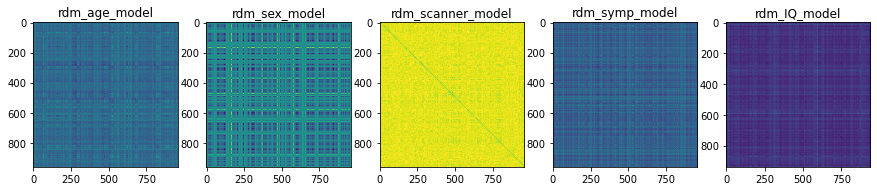

In [101]:
plt.figure(figsize=(15,5))
plt.subplot(1,5,1);plt.imshow(rdm_age_model);plt.title('rdm_age_model');
plt.subplot(1,5,2);plt.imshow(rdm_sex_model);plt.title('rdm_sex_model');
plt.subplot(1,5,3);plt.imshow(rdm_scanner_model);plt.title('rdm_scanner_model');
plt.subplot(1,5,4);plt.imshow(rdm_symp_model);plt.title('rdm_symp_model');
plt.subplot(1,5,5);plt.imshow(rdm_IQ_model);plt.title('rdm_IQ_model');

In [108]:
reducer = PCA(n_components=25)

In [110]:
X = reducer.fit_transform(arr.reshape(arr.shape[0],-1))

In [112]:
rdm_data = make_RDM(X,data_scale='ratio',metric='euclidean')

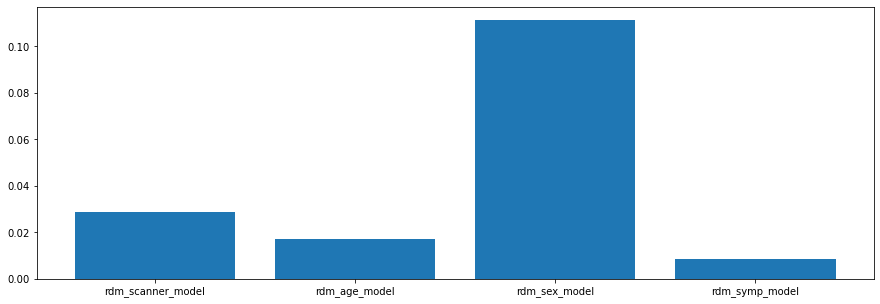

In [124]:
ys = [fit_rsa(rdm_data,model) for model in [rdm_scanner_model,rdm_age_model,rdm_sex_model,rdm_symp_model]]
xs = np.arange(len(ys))
lbls = ['rdm_scanner_model','rdm_age_model','rdm_sex_model','rdm_symp_model']

plt.figure(figsize=(15,5));
plt.bar(xs,ys);
plt.xticks(xs,labels=lbls);